<a href="https://colab.research.google.com/github/ravi-maithrey/skin-cancer-detection/blob/main/skin_cancerv1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!kaggle datasets download -d fanconic/skin-cancer-malignant-vs-benign

 99% 323M/325M [00:08<00:00, 22.1MB/s]
100% 325M/325M [00:08<00:00, 39.5MB/s]


In [ ]:
!pip install kaggle

In [ ]:
!mkdir ~/.kaggle

In [ ]:
!cp /content/kaggle.json ~/.kaggle/kaggle.json

In [ ]:
!unzip  ./skin-cancer-malignant-vs-benign.zip

In [ ]:
import os
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image
np.random.seed(11) 
from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score
import itertools

import keras
from keras.utils.np_utils import to_categorical
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras import backend as K
from keras.layers.normalization import BatchNormalization
from keras.utils.np_utils import to_categorical 
from keras.optimizers import Adam, RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from keras.wrappers.scikit_learn import KerasClassifier
from keras.applications.resnet50 import ResNet50
from keras import backend as K 

In [ ]:
folder_benign_train = 'archive/data/train/benign'
folder_malignant_train = 'archive/data/train/malignant'

folder_benign_test = 'archive/data/test/benign'
folder_malignant_test = 'archive/data/test/malignant'

In [ ]:
read = lambda imname: np.asarray(Image.open(imname).convert("RGB"))

ims_benign = [read(os.path.join(folder_benign_train, filename)) for filename in os.listdir(folder_benign_train)]
X_benign = np.array(ims_benign, dtype='uint8')
ims_malignant = [read(os.path.join(folder_malignant_train, filename)) for filename in os.listdir(folder_malignant_train)]
X_malignant = np.array(ims_malignant, dtype='uint8')

ims_benign = [read(os.path.join(folder_benign_test, filename)) for filename in os.listdir(folder_benign_test)]
X_benign_test = np.array(ims_benign, dtype='uint8')
ims_malignant = [read(os.path.join(folder_malignant_test, filename)) for filename in os.listdir(folder_malignant_test)]
X_malignant_test = np.array(ims_malignant, dtype='uint8')

In [ ]:
y_benign = np.zeros(X_benign.shape[0])
y_malignant = np.ones(X_malignant.shape[0])

y_benign_test = np.zeros(X_benign_test.shape[0])
y_malignant_test = np.ones(X_malignant_test.shape[0])


# Merge data 
X_train = np.concatenate((X_benign, X_malignant), axis = 0)
y_train = np.concatenate((y_benign, y_malignant), axis = 0)

X_test = np.concatenate((X_benign_test, X_malignant_test), axis = 0)
y_test = np.concatenate((y_benign_test, y_malignant_test), axis = 0)

# Shuffle data
s = np.arange(X_train.shape[0])
np.random.shuffle(s)
X_train = X_train[s]
y_train = y_train[s]

s = np.arange(X_test.shape[0])
np.random.shuffle(s)
X_test = X_test[s]
y_test = y_test[s]

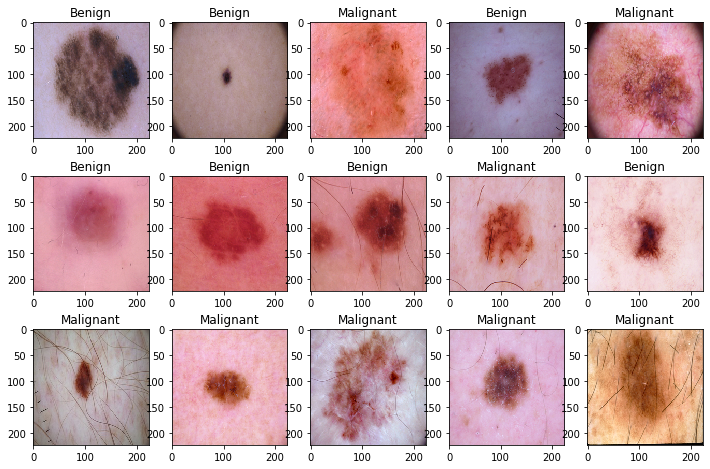

In [ ]:
w=40
h=30
fig=plt.figure(figsize=(12, 8))
columns = 5
rows = 3

for i in range(1, columns*rows +1):
    ax = fig.add_subplot(rows, columns, i)
    if y_train[i] == 0:
        ax.title.set_text('Benign')
    else:
        ax.title.set_text('Malignant')
    plt.imshow(X_train[i], interpolation='nearest')
plt.show()

In [ ]:
y_train = to_categorical(y_train, num_classes= 2)
y_test = to_categorical(y_test, num_classes= 2)

In [ ]:
X_train = X_train/255.
X_test = X_test/255.

In [ ]:
def build(input_shape= (224,224,3), lr = 1e-3, num_classes= 2,
          init= 'normal', activ= 'relu', optim= 'adam'):
    model = Sequential()

    model.add(Conv2D(128, kernel_size=(3, 3),padding = 'Same',input_shape=input_shape,activation= activ, kernel_initializer='glorot_uniform'))
    model.add(MaxPool2D(pool_size = (2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, kernel_size=(3, 3),padding = 'Same',activation =activ, kernel_initializer = 'glorot_uniform'))
    model.add(MaxPool2D(pool_size = (2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer=init))
    model.add(Dense(num_classes, activation='softmax'))
    model.summary()

    if optim == 'rmsprop':
        optimizer = RMSprop(lr=lr)

    else:
        optimizer = Adam(lr=lr)

    model.compile(optimizer = optimizer ,loss = "binary_crossentropy", metrics=["accuracy"])
    return model

# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                            patience=5, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=1e-7)

earlyStopping = keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                patience=5, 
                                                 verbose=1,)

In [ ]:
input_shape = (224,224,3)
lr = 1e-5
init = 'normal'
activ = 'relu'
optim = 'adam'
epochs = 50
batch_size = 64

model = build(lr=lr, init= init, activ= activ, optim=optim, input_shape= input_shape)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 128)     3584      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 128)     0         
_________________________________________________________________
dropout (Dropout)            (None, 112, 112, 128)     0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 64)      73792     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 56, 56, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 200704)            0

In [ ]:
history = model.fit(X_train, y_train, validation_split=0.2,
                    epochs= epochs, batch_size= batch_size, 
                    callbacks=[learning_rate_reduction,earlyStopping])

Epoch 1/50
33/33 [==============================] - 52s 575ms/step - loss: 0.9381 - accuracy: 0.5706 - val_loss: 0.6670 - val_accuracy: 0.6629
Epoch 2/50
33/33 [==============================] - 14s 422ms/step - loss: 0.8218 - accuracy: 0.5840 - val_loss: 0.6266 - val_accuracy: 0.6951
Epoch 3/50
33/33 [==============================] - 14s 423ms/step - loss: 0.7367 - accuracy: 0.6229 - val_loss: 0.6248 - val_accuracy: 0.7027
Epoch 4/50
33/33 [==============================] - 14s 425ms/step - loss: 0.6931 - accuracy: 0.6511 - val_loss: 0.6262 - val_accuracy: 0.6951
Epoch 5/50
33/33 [==============================] - 14s 423ms/step - loss: 0.6566 - accuracy: 0.6618 - val_loss: 0.6214 - val_accuracy: 0.7008
Epoch 6/50
33/33 [==============================] - 14s 423ms/step - loss: 0.6520 - accuracy: 0.6646 - val_loss: 0.6079 - val_accuracy: 0.6913
Epoch 7/50
33/33 [==============================] - 14s 421ms/step - loss: 0.6559 - accuracy: 0.6560 - val_loss: 0.6280 - val_accuracy: 0.7102

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


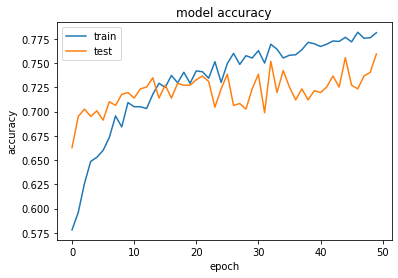

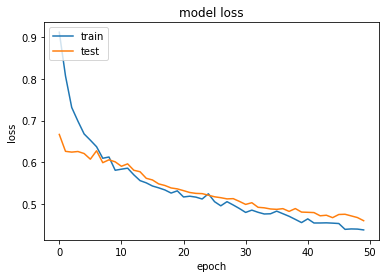

In [ ]:
print(history.history.keys())

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
y_pred = model.predict_classes(X_test)
print(accuracy_score(np.argmax(y_test, axis=1),y_pred))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


0.7636363636363637


In [ ]:
model.evaluate(X_test,y_test)

21/21 [==============================] - 1s 65ms/step - loss: 0.4491 - accuracy: 0.7636


[0.44909238815307617, 0.7636363506317139]

In [ ]:
model.save("my_h5_model.h5")

In [ ]:
input_shape = (224,224,3)
lr = 1e-5
epochs = 50
batch_size = 64

model2 = ResNet50(include_top=True,
                 weights= None,
                 input_tensor=None,
                 input_shape=input_shape,
                 pooling='avg',
                 classes=2)

model2.compile(optimizer = Adam(lr) ,
              loss = "binary_crossentropy", 
              metrics=["accuracy"])



In [ ]:
model2.summary()

In [ ]:
history = model2.fit(X_train, y_train, validation_split=0.2,
                    epochs= epochs, batch_size= batch_size, verbose=2, 
                    callbacks=[learning_rate_reduction]
                   )

Epoch 1/50
33/33 - 60s - loss: 0.6980 - accuracy: 0.6686 - val_loss: 0.6904 - val_accuracy: 0.5360
Epoch 2/50
33/33 - 45s - loss: 0.4810 - accuracy: 0.7862 - val_loss: 0.6889 - val_accuracy: 0.5360
Epoch 3/50
33/33 - 44s - loss: 0.4247 - accuracy: 0.7985 - val_loss: 0.6952 - val_accuracy: 0.5360
Epoch 4/50
33/33 - 44s - loss: 0.3996 - accuracy: 0.8113 - val_loss: 0.7190 - val_accuracy: 0.5360
Epoch 5/50
33/33 - 44s - loss: 0.3777 - accuracy: 0.8203 - val_loss: 0.7929 - val_accuracy: 0.5360
Epoch 6/50
33/33 - 44s - loss: 0.3658 - accuracy: 0.8255 - val_loss: 0.8679 - val_accuracy: 0.5360
Epoch 7/50
33/33 - 45s - loss: 0.3454 - accuracy: 0.8359 - val_loss: 0.9430 - val_accuracy: 0.5360

Epoch 00007: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-06.
Epoch 8/50
33/33 - 45s - loss: 0.3378 - accuracy: 0.8412 - val_loss: 1.1252 - val_accuracy: 0.5360
Epoch 9/50
33/33 - 45s - loss: 0.3279 - accuracy: 0.8511 - val_loss: 1.1533 - val_accuracy: 0.5360
Epoch 10/50
33/33 - 44s - lo

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


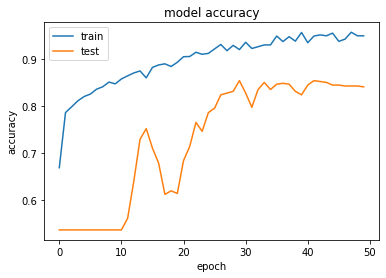

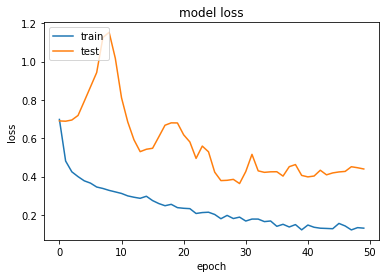

In [ ]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
model2.evaluate(X_test,y_test)

21/21 [==============================] - 6s 250ms/step - loss: 0.3858 - accuracy: 0.8591


[0.3857814371585846, 0.8590909242630005]

In [ ]:
model2.save("skin_Detect_resmodel.h5")

In [ ]:
%cd ..
from google.colab import drive
drive.mount('/content/gdrive')

/
Mounted at /content/gdrive


In [ ]:
# this creates a symbolic link so that now the path /content/gdrive/My\ Drive/ is equal to /mydrive
!ln -s /content/gdrive/My\ Drive/ /mydrive
!ls /mydrive

In [ ]:
!cp -r /content/my_h5_model.h5 /mydrive
!cp -r /content/skin_Detect_resmodel.h5 /mydrive   